## Introduction
cette fois on va essayer de train station par station le modèle

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from timeseries_utils import*
from xgboost import plot_importance, plot_tree

data_X = pd.read_csv('x_train.csv')
data_X['date']=pd.to_datetime(data_X['date'])
data_y = pd.read_csv('y_train.csv')
X_a_tester = pd.read_csv('x_test.csv')
nb_stations=data_X['station'].nunique()

data_X['y']=data_y['y']



In [2]:
ordinal_encoder=OrdinalEncoder()
X=data_X.copy()
# X['date']=ordinal_encoder.fit_transform(X[['date']])
X=X.set_index(['station'])
X['jour'] = X['date'].dt.day.astype(int)
X['mois'] = X['date'].dt.month.astype(int)
X['année'] = X['date'].dt.year.astype(int)
X=X.drop(['date'],axis = 1)
display(X)

,job,ferie,vacances,y,jour,mois,année
station,,,,,,,
1J7,1,1,1,7,1,1,2015
O2O,1,1,1,0,1,1,2015
8QR,1,1,1,9,1,1,2015
UMC,1,1,1,9,1,1,2015
FK3,1,1,1,28,1,1,2015
...,...,...,...,...,...,...,...
V2P,0,0,1,1227,31,12,2022
N9K,0,0,1,544,31,12,2022
P6E,0,0,1,92,31,12,2022


In [3]:
models={}
error = 0
steps = 365
i=0
for station in data_X['station'].unique():
    model = XGBRegressor()
    X_station = X.loc[station]
    y_station = X_station['y']
    X_station=X_station.drop(['y'],axis=1)
    X_train = X_station[:-steps]
    y_train = y_station[:-steps]
    X_test = X_station[-steps:]
    y_test = y_station[-steps:]
    #print(i/nb_stations)
    models[station] = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    error+= mean_absolute_error(y_pred,y_test)

print(error/nb_stations)


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:37:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:52: Empty dataset at worker: 0
  warnings.warn(smsg, UserWarning)


514.3400233136192


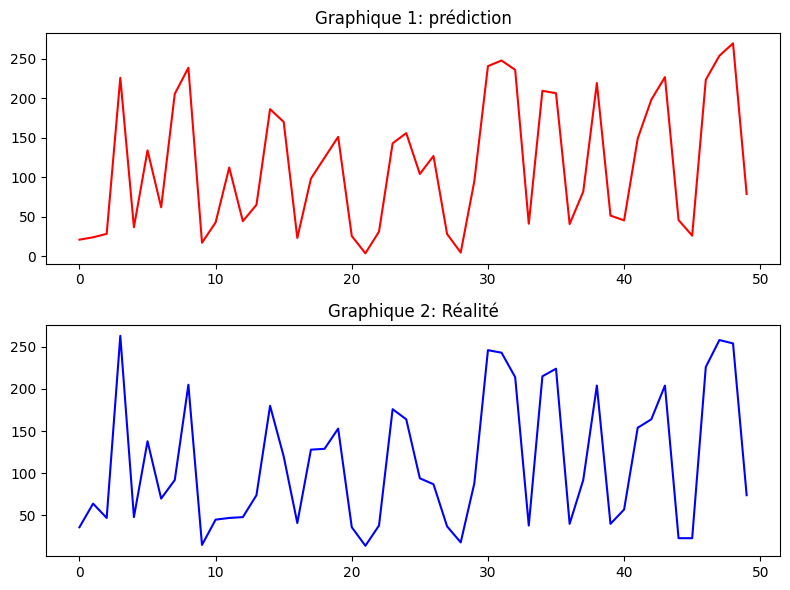

In [4]:
X_XTG = X.loc['1J7']
y_XTG = pd.DataFrame(X_XTG['y'])
X_XTG=X_XTG.drop(['y'],axis=1)

X_test = X_XTG[-steps:]
y_test = y_XTG[-steps:]

y_pred = models['1J7'].predict(X_test)
y_plot = np.array(y_test)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Premier graphique (en haut)
ax1.plot(y_pred[0:50], 'r-')
ax1.set_title('Graphique 1: prédiction')

# Deuxième graphique (en bas)
ax2.plot(y_plot[0:50], 'b-')
ax2.set_title('Graphique 2: Réalité')

# Ajuster les paramètres de la mise en page
plt.tight_layout()

# Afficher les graphiques


In [6]:
y_pred = pd.read_csv('y_soum_alea.csv')
X_test = pd.read_csv('x_test.csv')
X_test['date'] = pd.to_datetime(X_test['date'])
X_test['jour'] = X_test['date'].dt.day.astype(int)
X_test['mois'] = X_test['date'].dt.month.astype(int)
X_test['année'] = X_test['date'].dt.year.astype(int)
X_test = X_test.drop(['date'],axis=1)
display(X_test)

for station, model in models.items():
    station_data = X_test[X_test['station'] == station]
    X_station = station_data[['job', 'ferie', 'vacances','jour','mois','année']]
    pred = model.predict(X_station)
    i=0
    for index in X_station.index:
        # Remplacer la valeur prédite dans y_pred à l'index correspondant
        y_pred.at[index, 'y'] = pred[i]
        i += 1

y_pred.to_csv('predictions.csv', index=False)

,index,station,job,ferie,vacances,jour,mois,année
0,2023-01-01_1J7,1J7,0,1,1,1,1,2023
1,2023-01-01_O2O,O2O,0,1,1,1,1,2023
2,2023-01-01_8QR,8QR,0,1,1,1,1,2023
3,2023-01-01_L58,L58,0,1,1,1,1,2023
4,2023-01-01_UMC,UMC,0,1,1,1,1,2023
...,...,...,...,...,...,...,...,...
78647,2023-05-31_N9K,N9K,1,0,0,31,5,2023
78648,2023-05-31_P6E,P6E,1,0,0,31,5,2023
78649,2023-05-31_BDC,BDC,1,0,0,31,5,2023
78650,2023-05-31_QD6,QD6,1,0,0,31,5,2023


Maintenant on fait des lags ?

In [ ]:
X_2 = data_X.copy()
X_2['jour'] = X_2['date'].dt.day.astype(int)
X_2['mois'] = X_2['date'].dt.month.astype(int)
X_2['année'] = X_2['date'].dt.year.astype(int)

X_2=X_2.sort_values(by = ['station', 'date'])
X_lags = make_lags(X_2['y'],lags=12)
X_2lags = pd.concat([X_2,X_lags],axis=1).dropna()
X_2lags=X_2lags.set_index(['station'])
X_2lags=X_2lags.drop(['date'],axis=1)
display(X_2lags)

,job,ferie,vacances,y,jour,mois,année,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,y_lag_11,y_lag_12
station,,,,,,,,,,,,,,,,,,,
003,1,0,0,240,13,1,2015,244.0,33.0,93.0,216.0,250.0,231.0,228.0,245.0,31.0,53.0,57.0,30.0
003,1,0,0,259,14,1,2015,240.0,244.0,33.0,93.0,216.0,250.0,231.0,228.0,245.0,31.0,53.0,57.0
003,1,0,0,250,15,1,2015,259.0,240.0,244.0,33.0,93.0,216.0,250.0,231.0,228.0,245.0,31.0,53.0
003,1,0,0,233,16,1,2015,250.0,259.0,240.0,244.0,33.0,93.0,216.0,250.0,231.0,228.0,245.0,31.0
003,0,0,0,107,17,1,2015,233.0,250.0,259.0,240.0,244.0,33.0,93.0,216.0,250.0,231.0,228.0,245.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXY,1,0,1,4507,27,12,2022,3807.0,1476.0,2360.0,4470.0,5068.0,4898.0,5156.0,4949.0,1912.0,2849.0,6236.0,6604.0
ZXY,1,0,1,4187,28,12,2022,4507.0,3807.0,1476.0,2360.0,4470.0,5068.0,4898.0,5156.0,4949.0,1912.0,2849.0,6236.0
ZXY,1,0,1,4271,29,12,2022,4187.0,4507.0,3807.0,1476.0,2360.0,4470.0,5068.0,4898.0,5156.0,4949.0,1912.0,2849.0


In [ ]:
# X = make_lags(y,lags=12).dropna()
models={}
error = 0
steps = 365
i=0
for station in data_X['station'].unique():
    model = XGBRegressor()
    X_station = X_2lags.loc[station]
    y_station = X_station['y']
    X_station=X_station.drop(['y'],axis=1)
    #y_station=y_station[-12:]
    X_train = X_station[:-steps]
    y_train = y_station[:-steps]
    X_test = X_station[-steps:]
    y_test = y_station[-steps:]
    print(i/nb_stations)
    i+=1
    models[station] = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    error+= mean_absolute_error(y_pred,y_test)

print(error/nb_stations)



0.0
0.002277904328018223
0.004555808656036446
0.00683371298405467
0.009111617312072893
0.011389521640091117
0.01366742596810934
0.015945330296127564
0.018223234624145785
0.02050113895216401
0.022779043280182234
0.025056947608200455
0.02733485193621868
0.029612756264236904
0.03189066059225513
0.03416856492027335
0.03644646924829157
0.0387243735763098
0.04100227790432802
0.04328018223234624
0.04555808656036447
0.04783599088838269
0.05011389521640091
0.05239179954441914
0.05466970387243736
0.05694760820045558
0.05922551252847381
0.06150341685649203
0.06378132118451026
0.06605922551252848
0.0683371298405467
0.07061503416856492
0.07289293849658314
0.07517084282460136
0.0774487471526196
0.07972665148063782
0.08200455580865604
0.08428246013667426
0.08656036446469248
0.0888382687927107
0.09111617312072894
0.09339407744874716
0.09567198177676538
0.0979498861047836
0.10022779043280182
0.10250569476082004
0.10478359908883828
0.1070615034168565
0.10933940774487472
0.11161731207289294
0.11389521640

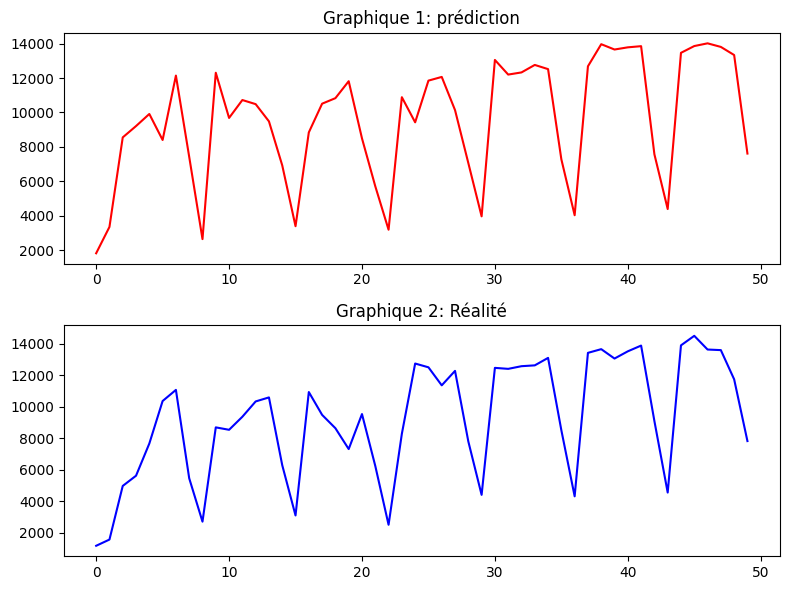

In [ ]:
X_XTG = X_2lags.loc['XTG']
y_XTG = pd.DataFrame(X_XTG['y'])
X_XTG=X_XTG.drop(['y'],axis=1)

X_test = X_XTG[-steps:]
y_test = y_XTG[-steps:]

y_pred = models['XTG'].predict(X_test)
y_plot = np.array(y_test)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Premier graphique (en haut)
ax1.plot(y_pred[0:50], 'r-')
ax1.set_title('Graphique 1: prédiction')

# Deuxième graphique (en bas)
ax2.plot(y_plot[0:50], 'b-')
ax2.set_title('Graphique 2: Réalité')

# Ajuster les paramètres de la mise en page
plt.tight_layout()

# Afficher les graphiques


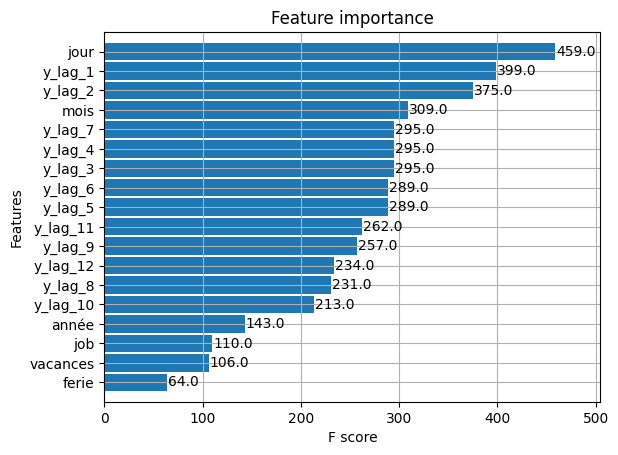

In [ ]:
_ = plot_importance(model, height=0.9 ,max_num_features = 20)

In [ ]:
y_pred = pd.read_csv('y_soum_alea.csv')
X_test = pd.read_csv('x_test.csv')
X_concat = data_X.copy()
X_test['date'] = pd.to_datetime(X_test['date'])
X_test['jour'] = X_test['date'].dt.day.astype(int)
X_test['mois'] = X_test['date'].dt.month.astype(int)
X_test['année'] = X_test['date'].dt.year.astype(int)
#X_concat = X_concat.drop(['y'],)

for station, model in models.items():
    station_data = X_test[X_test['station'] == station]
    X_station = station_data[['job', 'ferie', 'vacances','jour','mois','année']]
    pred = model.predict(X_station)
    i=0
    for index in X_station.index:
        # Remplacer la valeur prédite dans y_pred à l'index correspondant
        y_pred.at[index, 'y'] = pred[i]
        i += 1

y_pred.to_csv('predictions.csv', index=False)

ValueError: feature_names mismatch: ['job', 'ferie', 'vacances', 'jour', 'mois', 'année', 'y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5', 'y_lag_6', 'y_lag_7', 'y_lag_8', 'y_lag_9', 'y_lag_10', 'y_lag_11', 'y_lag_12'] ['job', 'ferie', 'vacances', 'jour', 'mois', 'année']
expected y_lag_11, y_lag_4, y_lag_9, y_lag_5, y_lag_12, y_lag_7, y_lag_8, y_lag_6, y_lag_1, y_lag_10, y_lag_2, y_lag_3 in input data